In [ ]:
# If running on Google Colab, run this cell copy some data files
# Alternatively, upload your own CSV file of NAV data.
# Your CSV file must contain colunms named DATE and NAV
# For Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Additional setup for Colab
    # !pip install -q some-package
except:
    # Apparently not running on Colab
    print("Apparently not running on Colab.")

Apparently not running on Colab.


In [14]:
# Code uses numpy, matplotlib for plots, and sklearn for reression
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [16]:
# Specify the name of a CSV file containing nav (price) data and dates.
# First line should be comment line naming the fields, and should include
# field names "DATE" and "NAV". 

FILENAME = "KKP-ACT-FIXED.csv"

FILENAME = "BFIXED-20250912.csv"

# How many days of data to use?
# Using more data can help you see historical outliers,
# but means that linear regression may not fit the current trend well.
NUM_DAYS = 180

# A descriptive name displayed on plots, e.g. the fund name.
# You can replace this with a string literal, e.g. DESCRIPTION = "KKP Active Fixed"
DESCRIPTION = os.path.splitext(os.path.basename(FILENAME))[0]

# Create a data frame, using only the columns labeled 'DATE' and 'NAV'
df = pd.read_csv(FILENAME, usecols=["DATE","NAV"], parse_dates=["DATE"])
# Remove unused columns is not needed. Use 'usecols=' instead.
# df = df.drop(columns=["THAIDATE","Month"]).rename(columns={"DATE": "Date"})

# Pandas recommends avoiding sort with inplace=True due to possibly unexpected behavior
df = df.sort_values("DATE", ascending=True).reset_index(drop=True)

# Ensure Date is datetime and set as index
df = df.set_index("DATE")

# Use only recent data
df = df.tail(NUM_DAYS)

df.tail(10)


,NAV
DATE,
2025-09-01,13.5088
2025-09-02,13.5121
2025-09-03,13.5121
2025-09-04,13.5127
2025-09-05,13.5145
2025-09-08,13.5143
2025-09-09,13.5158
2025-09-10,13.5113
2025-09-11,13.5034


In [17]:
# Compute the relative price differences including effect of time (number of days between rows).
# days = df["DATE"].diff().dt.days
# If the "Date" is the index, then do this instead:
days = df.index.to_series().diff().dt.days

# Window size for moving averages
window_size = 5

# diff() gives absolute diff, pct_change() is relative change (x(t)-x(t-1))/x(t-1)
df["NAV_DIF"] = df["NAV"].diff() / days
df["NAV_DIF_PCT"] = df["NAV"].pct_change() / days * 100

# N-day moving average of price based on number of elapsed calendar days
window = f"{window_size}D"  # "5D"
df["NAV_MA"] = df["NAV"].rolling(window=window_size).mean()

# statistical magnitude of NAV deviatiation from MA
df["Dev_%"] = (df["NAV"] - df["NAV_MA"]) / df["NAV_MA"] * 100

# df.tail(10)

In [18]:
# Compute Z-scores and Bollinger Bands using daily returns

# For Logarithmic returns use:
# daily_return = np.log(df["NAV"] / df["NAV"].shift(1) / days)
# For simple % differences use
# daily_return = (df["NAV"] / df["NAV"].shift(1) - 1) * 100
# This version accounts for number of elapsed calendar days between NAV data points
daily_return = df["NAV_DIF_PCT"]
# Window size (days) for rolling averages (or use same size as MA window)
window = f"{window_size}D"
rolling_mean = daily_return.rolling(window_size).mean()
rolling_std = daily_return.rolling(window_size).std()

df["Daily_return"] = daily_return
df["Return_Z_Score"] = (daily_return - rolling_mean) / rolling_std

# Bollinger Bands of Daily Returns
df["Upper_1std"] = rolling_mean + 1 * rolling_std
df["Upper_2std"] = rolling_mean + 2 * rolling_std
df["Lower_1std"] = rolling_mean - 1 * rolling_std
df["Lower_2std"] = rolling_mean - 2 * rolling_std

df.tail(20)

,NAV,NAV_DIF,NAV_DIF_PCT,NAV_MA,Dev_%,Daily_return,Return_Z_Score,Upper_1std,Upper_2std,Lower_1std,Lower_2std
DATE,,,,,,,,,,,
2025-08-18,13.4925,0.001967,0.014582,13.48066,0.087830,0.014582,-0.420374,0.046880,0.069619,0.001402,-0.021337
2025-08-19,13.4927,0.000200,0.001482,13.48616,0.048494,0.001482,-0.907189,0.046931,0.070761,-0.000729,-0.024560
2025-08-20,13.4946,0.001900,0.014082,13.49004,0.033803,0.014082,-0.370925,0.046846,0.070745,-0.000953,-0.024852
2025-08-21,13.4941,-0.000500,-0.003705,13.49210,0.014823,-0.003705,-1.294770,0.019595,0.029749,-0.000712,-0.010866
2025-08-22,13.4974,0.003300,0.024455,13.49426,0.023269,0.024455,1.268238,0.021436,0.032692,-0.001077,-0.012334
2025-08-25,13.5017,0.001433,0.010619,13.49610,0.041493,0.010619,0.112004,0.020392,0.031398,-0.001619,-0.012625
2025-08-26,13.5019,0.000200,0.001481,13.49794,0.029338,0.001481,-0.718270,0.020392,0.031398,-0.001619,-0.012625
2025-08-27,13.5013,-0.000600,-0.004444,13.49928,0.014964,-0.004444,-0.837173,0.017776,0.029870,-0.006413,-0.018508
2025-08-28,13.5022,0.000900,0.006666,13.50090,0.009629,0.006666,-0.099833,0.018670,0.029583,-0.003158,-0.014072


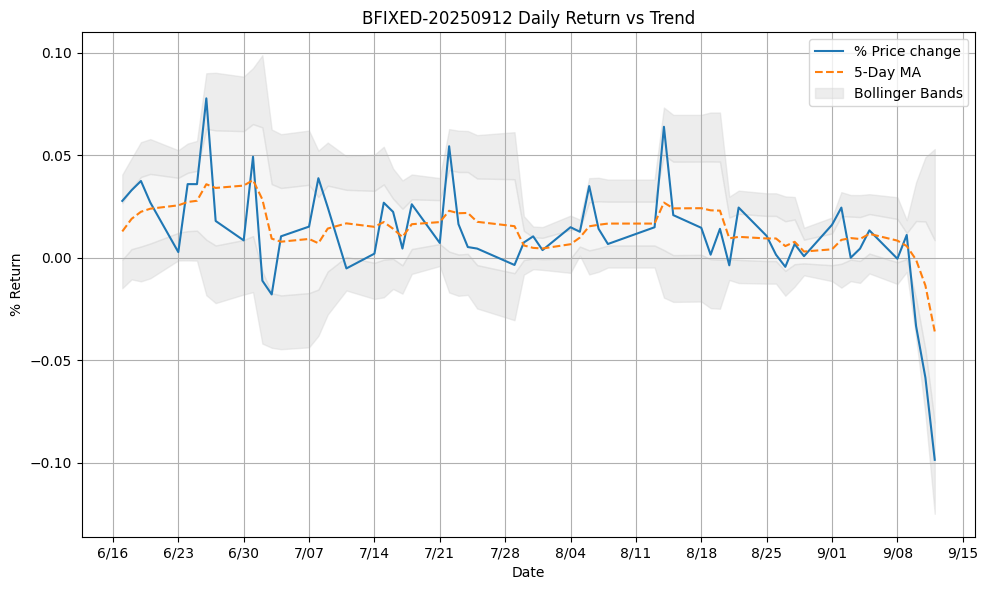

In [19]:
# Plot NAV, SMA, and Bollinger Bands
import matplotlib.dates as mdates

# How many most recent days to plot?  Plotting too much date makes it hard to read.  
plot_days = 12 * 5
plot_days = min(plot_days, len(df) - 1)

# Locate x-ticks every 5 days
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()

recent = df.tail(plot_days)

plt.figure(figsize=(10,6))
# The df.index is Date, so plot df.index instead of df["Date"]
plt.plot(recent.index, recent["Daily_return"], label="% Price change")  # marker="o"
plt.plot(recent.index, rolling_mean.tail(plot_days), label=f"{window_size}-Day MA", linestyle="--")

# Separate Bollinger Bands into 1 and 2-stdev
fill_color = "lightgray"
plt.fill_between(recent.index, recent["Lower_2std"], recent["Lower_1std"],  color=fill_color, alpha=0.4,
                 label="Bollinger Bands")
plt.fill_between(recent.index, recent["Upper_2std"], recent["Upper_1std"],  color=fill_color, alpha=0.4)
# middle band
plt.fill_between(recent.index, recent["Lower_1std"], recent["Upper_1std"],  color=fill_color, alpha=0.2)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
plt.gca().xaxis.set_major_locator(xticks)
plt.title(f"{DESCRIPTION} Daily Return vs Trend")
plt.xlabel("Date")
plt.ylabel("% Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

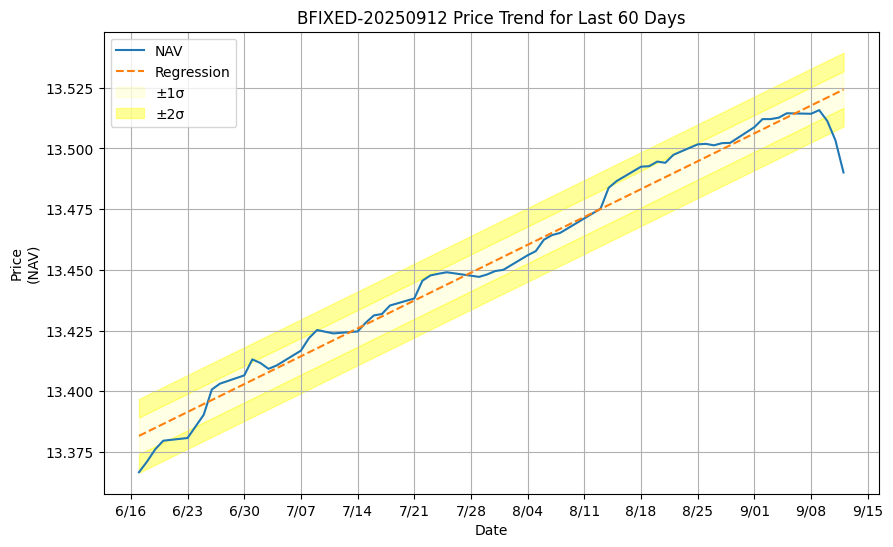

In [20]:
# Regression of NAV and regression trend line for last N days
N = 12 * 5
N = min(N, len(df) - 1)
recent = df.tail(N).copy()
# Convert dates to integer number of days since beginning of the data
X = (recent.index - recent.index[0]).days.values.reshape(-1,1)
Y = recent["NAV"].values

model = LinearRegression().fit(X, Y)
trend = model.predict(X)

# For confidence bands
residuals = Y - trend
sigma = np.std(residuals)

plt.figure(figsize=(10,6))
plt.plot(recent.index, Y, label="NAV")  # marker="o"
plt.plot(recent.index, trend, linestyle="--", label="Regression")

# 1- and 2-stdev bands
fill_color = "yellow"
plt.fill_between(recent.index, trend - sigma, trend + sigma, color=fill_color, alpha=0.1, label="±1σ")
plt.fill_between(recent.index, trend - 2*sigma, trend - 1*sigma, color=fill_color, alpha=0.4, label="±2σ")
plt.fill_between(recent.index, trend + 2*sigma, trend + 1*sigma, color=fill_color, alpha=0.4)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
# Locate x-ticks every 5 days:
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(xticks)
plt.title(f"{DESCRIPTION} Price Trend for Last {N} Days")
plt.xlabel("Date")
plt.ylabel("Price\n(NAV)")
plt.legend()
plt.grid(True)
plt.show()



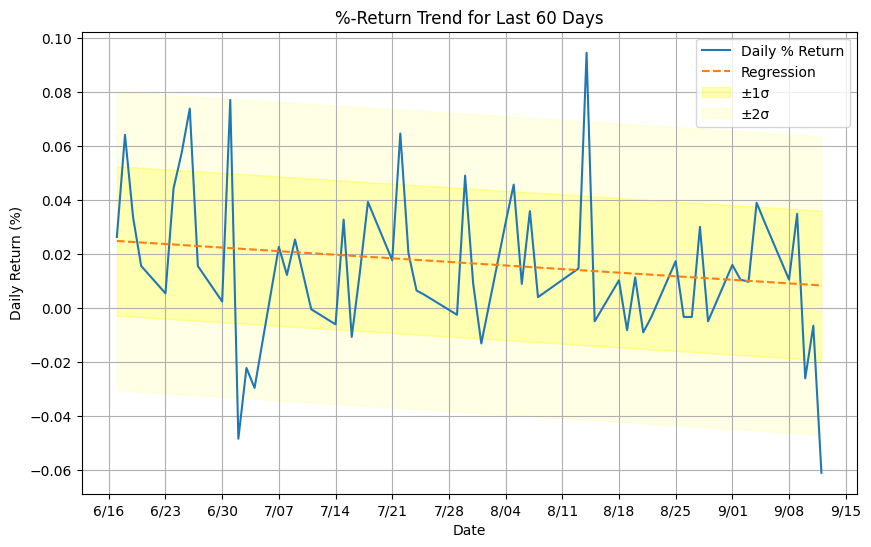

In [11]:
# Linear Regression using daily % return as Y variable
# Regression of NAV and regression trend line for last N days
N = 12 * 5
N = min(N, len(df) - 1)
recent = df.tail(N).copy()
# Convert dates to integer number of days since beginning of the data
X = (recent.index - recent.index[0]).days.values.reshape(-1,1)
Y = recent["NAV_DIF_PCT"].values

# regression but exclude M days on both ends
M = 1
model = LinearRegression().fit(X[M:-M], Y[M:-M]) if M > 0 else LinearRegression().fit(X, Y)
trend = model.predict(X)

# For confidence bands
residuals = Y - trend
sigma = np.std(residuals)

plt.figure(figsize=(10,6))
plt.plot(recent.index, Y, label="Daily % Return")  # marker="o"
plt.plot(recent.index, trend, linestyle="--", label="Regression")

# 1- and 2-stdev bands
fill_color = "yellow"
plt.fill_between(recent.index, trend - sigma, trend + sigma, color=fill_color, alpha=0.3, label="±1σ")
plt.fill_between(recent.index, trend - 2*sigma, trend - 1*sigma, color=fill_color, alpha=0.1, label="±2σ")
plt.fill_between(recent.index, trend + 2*sigma, trend + 1*sigma, color=fill_color, alpha=0.1)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
# Locate x-ticks every 5 days:
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(xticks)
plt.title(f"%-Return Trend for Last {N} Days")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.grid(True)
plt.show()